# Analyse exploratoire des données (EDA)

Ce notebook propose une exploration complète des séries de demande énergétique et de leurs principaux déterminants gader apres selection pour une zone donnée.

## 1. Imports et chargement des données

In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
os.chdir("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pathlib import Path

plt.rcParams['figure.figsize'] = (10, 5)
sns.set_style("whitegrid")

In [2]:
# Chargement du DataFrame traité (daily)
processed_dir = Path("data/processed")
files = list(processed_dir.glob("*_processed_daily.parquet"))
zone_file = files[0]
zone = zone_file.stem.replace("_processed_daily","")
df = pd.read_parquet(zone_file)
print(f"Zone analysée : {zone}")

Zone analysée : Baleares


## 2. Aperçu global des données

In [3]:
df.info()
display(df.head())
display(df.describe().T)
print("Valeurs manquantes par colonne :")
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2803 entries, 2016-05-01 00:00:00+00:00 to 2024-01-02 00:00:00+00:00
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lag_3d          2803 non-null   float64
 1   T_sq            2803 non-null   float64
 2   lag_2d          2803 non-null   float64
 3   lag_6d          2803 non-null   float64
 4   temp_rmean_7    2803 non-null   float64
 5   lag_7d          2803 non-null   float64
 6   temperature_2m  2803 non-null   float64
 7   lag_1d          2803 non-null   float64
 8   rmean_7d        2803 non-null   float64
 9   temp_rmean_12   2803 non-null   float64
 10  WindChill       2803 non-null   float64
 11  lag_30d         2803 non-null   float64
 12  lag_4d          2803 non-null   float64
 13  demand          2803 non-null   float64
 14  temp_rmean_3    2803 non-null   float64
dtypes: float64(15)
memory usage: 350.4 KB


,lag_3d,T_sq,lag_2d,lag_6d,temp_rmean_7,lag_7d,temperature_2m,lag_1d,rmean_7d,temp_rmean_12,WindChill,lag_30d,lag_4d,demand,temp_rmean_3
datetime,,,,,,,,,,,,,,,
2016-05-01 00:00:00+00:00,14644.677,177.000851,13922.559,13882.115,15.412500,12324.100,13.304167,967.987,12135.243429,15.905556,13.304167,14851.571,14181.611,13360.694,14.984722
2016-05-02 00:00:00+00:00,13922.559,226.001111,967.987,13987.061,15.393452,13882.115,15.033333,13360.694,12245.445429,15.717361,15.033333,13712.197,14644.677,14653.529,14.625000
2016-05-03 00:00:00+00:00,967.987,281.540434,13360.694,14181.611,15.557143,13987.061,16.779167,14653.529,12355.998571,15.726736,16.779167,12713.297,13922.559,14760.933,15.038889
2016-05-04 00:00:00+00:00,13360.694,282.660156,14653.529,14644.677,15.642857,14181.611,16.812500,14760.933,12447.051143,15.783333,16.812500,14273.122,967.987,14818.979,16.208333
2016-05-05 00:00:00+00:00,14653.529,275.421684,14760.933,13922.559,15.739286,14644.677,16.595833,14818.979,12503.353000,15.769792,16.595833,14546.843,13360.694,15038.790,16.729167


,count,mean,std,min,25%,50%,75%,max
lag_3d,2803.0,15506.248415,4379.808409,393.674000,13363.441500,14857.999000,17730.069500,27537.398000
T_sq,2803.0,377.452840,223.956446,26.608403,182.587656,319.217778,566.340877,1004.890000
lag_2d,2803.0,15501.211967,4388.906890,393.674000,13360.859500,14857.999000,17730.069500,27537.398000
lag_6d,2803.0,15505.799177,4379.923969,393.674000,13363.441500,14857.999000,17730.069500,27537.398000
temp_rmean_7,2803.0,18.521691,5.747564,7.346429,13.510714,18.079762,23.925000,29.858929
lag_7d,2803.0,15504.945984,4380.310862,393.674000,13360.859500,14857.999000,17730.069500,27537.398000
temperature_2m,2803.0,18.518233,5.877091,5.158333,13.512500,17.866667,23.797917,31.700000
lag_1d,2803.0,15501.024113,4388.985752,393.674000,13360.859500,14857.999000,17730.069500,27537.398000
rmean_7d,2803.0,15504.679196,3461.062622,8713.048429,13038.009143,14610.743000,17343.742857,26073.961286
temp_rmean_12,2803.0,18.525348,5.694889,7.967361,13.422743,17.937847,23.928993,29.267361


Valeurs manquantes par colonne :
lag_3d            0
T_sq              0
lag_2d            0
lag_6d            0
temp_rmean_7      0
lag_7d            0
temperature_2m    0
lag_1d            0
rmean_7d          0
temp_rmean_12     0
WindChill         0
lag_30d           0
lag_4d            0
demand            0
temp_rmean_3      0
dtype: int64


## 3. Visualisation de la demande

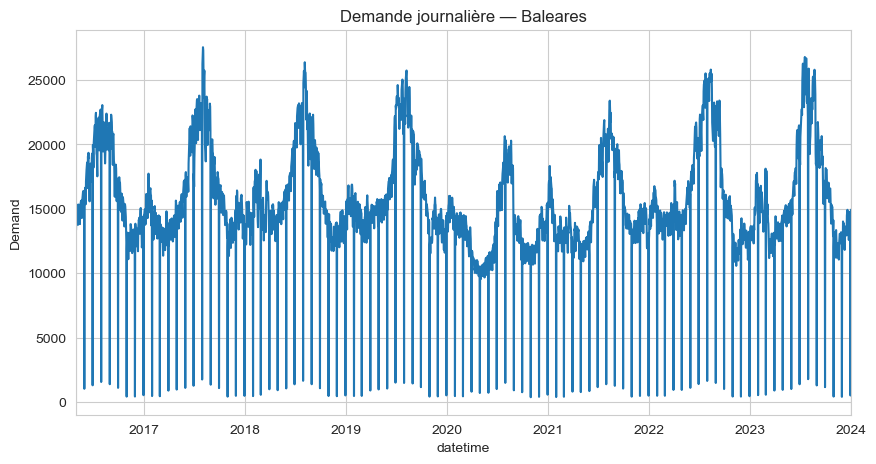

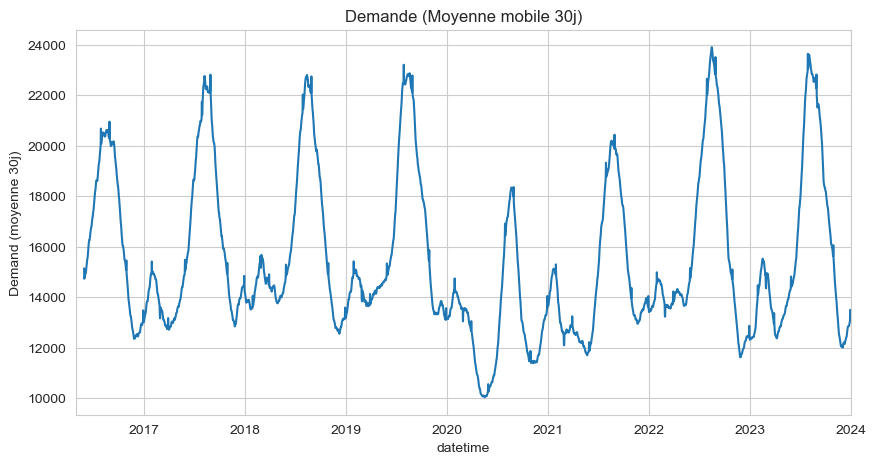

In [4]:
plt.figure()
df['demand'].plot(title=f"Demande journalière — {zone}")
plt.ylabel("Demand")
plt.show()

# Moyenne mobile sur 30 jours
plt.figure()
df['demand'].rolling(30).mean().plot(title="Demande (Moyenne mobile 30j)")
plt.ylabel("Demand (moyenne 30j)")
plt.show()

## 4. Analyse saisonnière et par année

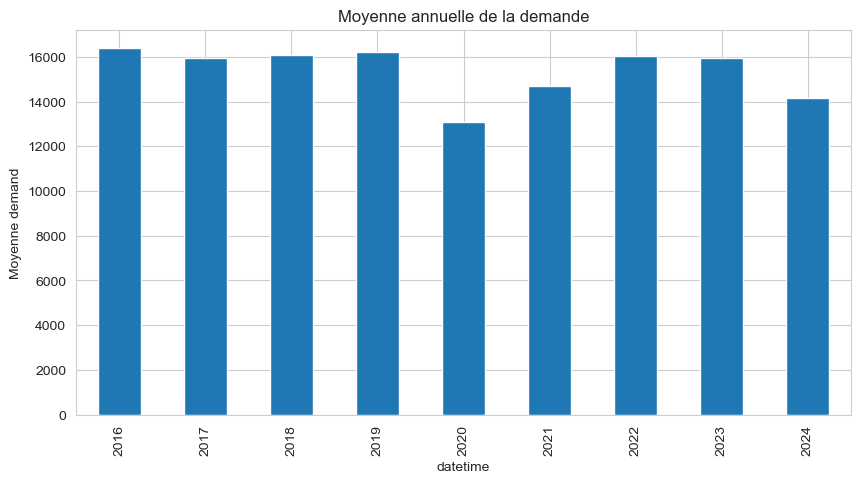

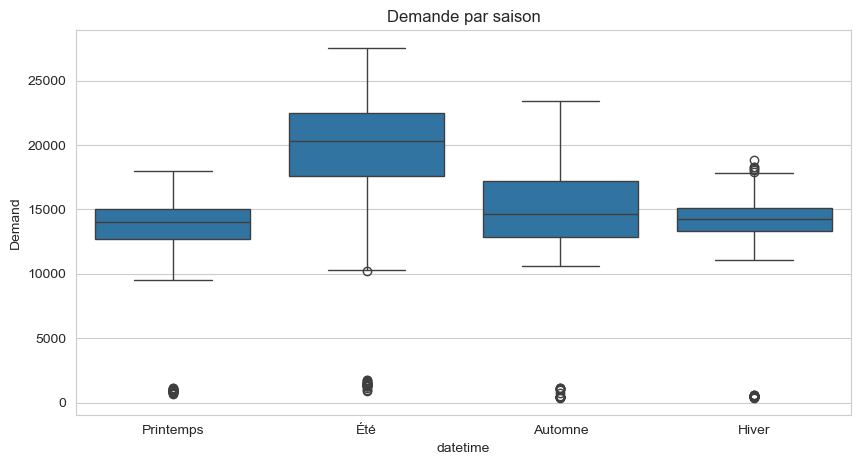

In [5]:
# Par année
plt.figure()
df['demand'].groupby(df.index.year).mean().plot.bar(title="Moyenne annuelle de la demande")
plt.ylabel("Moyenne demand")
plt.show()

# Par saison
seasons = ((df.index.month%12 +3)//3).map({1:'Hiver',2:'Printemps',3:'Été',4:'Automne'})
plt.figure()
sns.boxplot(x=seasons, y=df['demand'])
plt.title("Demande par saison")
plt.ylabel("Demand")
plt.show()

## 5. Corrélations croisées

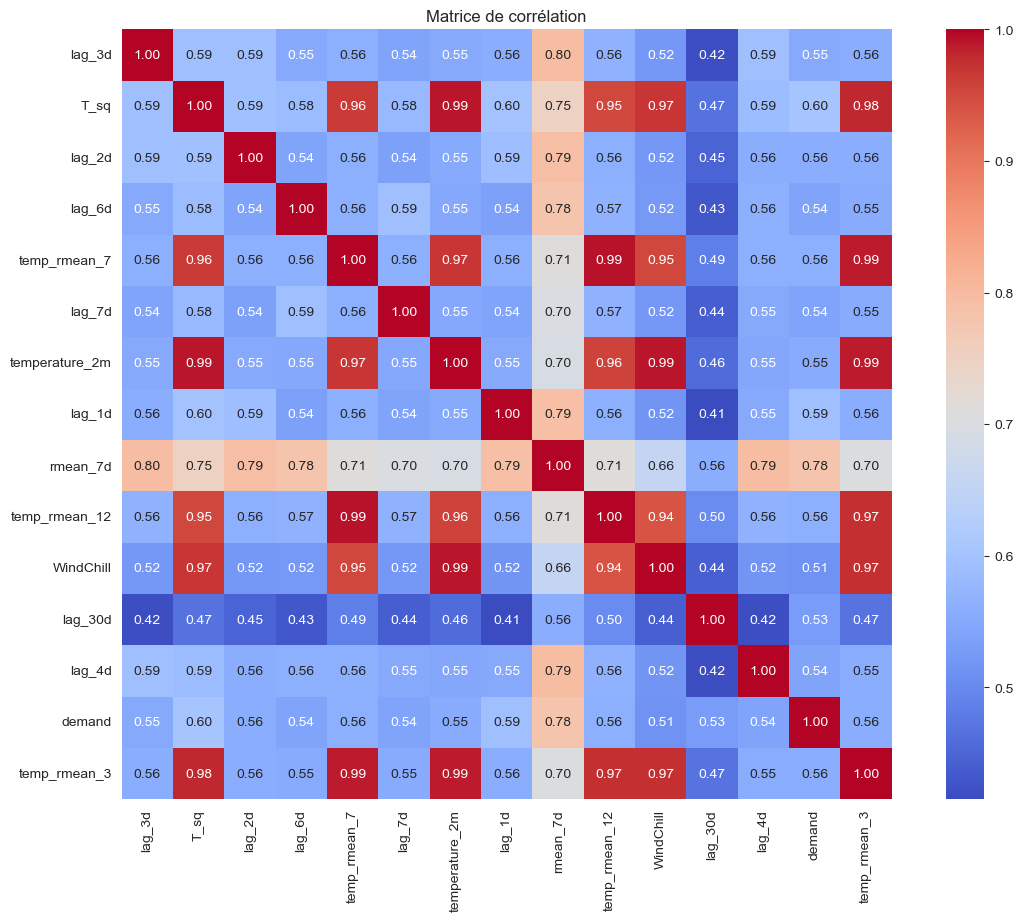

In [6]:
corr = df.corr()
plt.figure(figsize=(14,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matrice de corrélation")
plt.show()

## 6. Distribution de la demande et boxplot mensuel

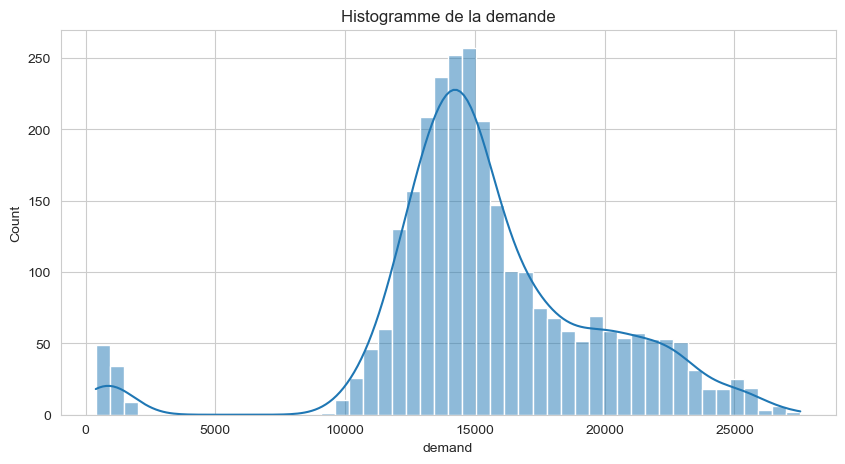

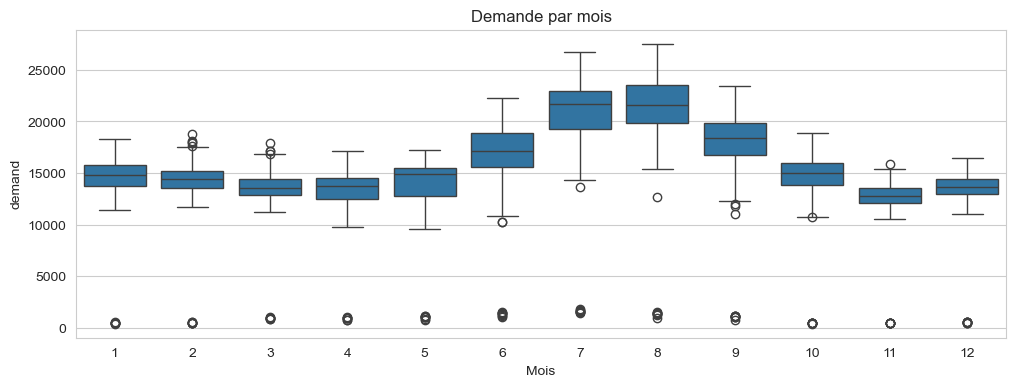

In [7]:
plt.figure()
sns.histplot(df['demand'], bins=50, kde=True)
plt.title("Histogramme de la demande")
plt.show()

plt.figure(figsize=(12,4))
sns.boxplot(x=df.index.month, y=df['demand'])
plt.title("Demande par mois")
plt.xlabel("Mois")
plt.show()

## 7. Analyse cyclique : jours de la semaine

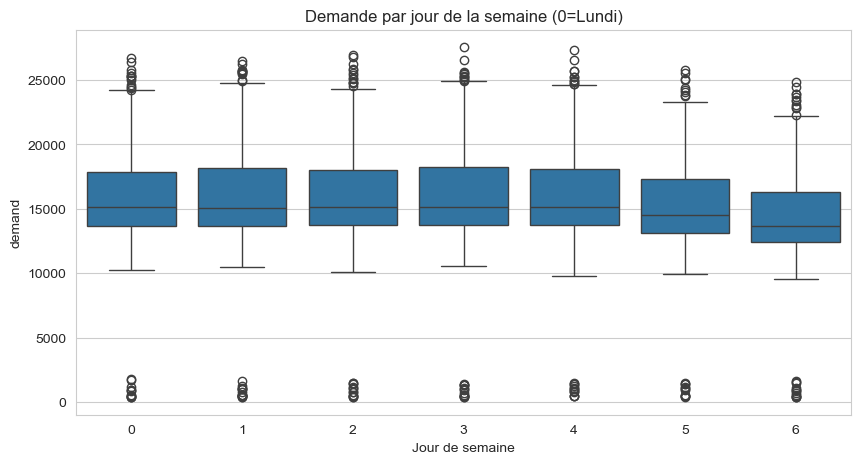

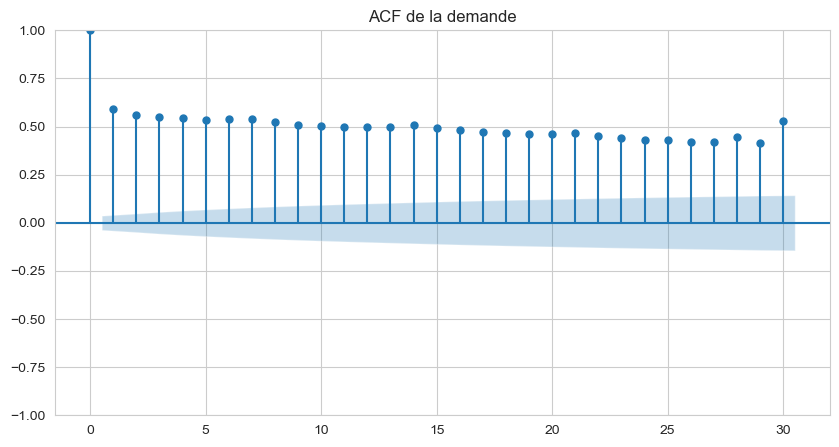

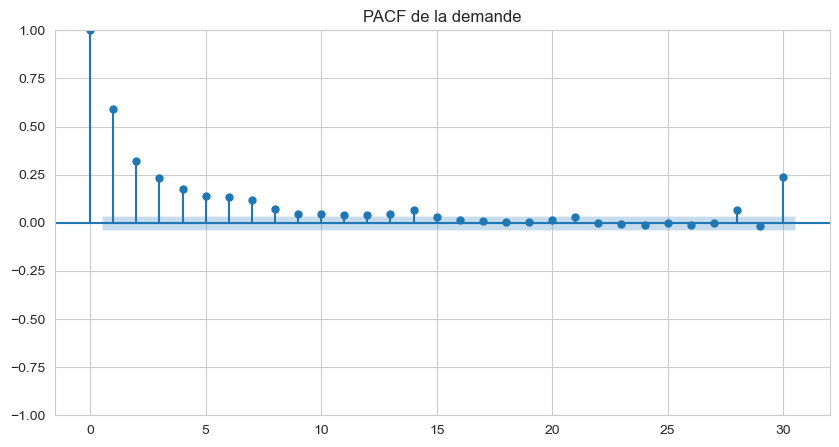

In [8]:
plt.figure()
sns.boxplot(x=df.index.dayofweek, y=df['demand'])
plt.title("Demande par jour de la semaine (0=Lundi)")
plt.xlabel("Jour de semaine")
plt.show()

# Autocorrélation et PACF
plot_acf(df['demand'].dropna(), lags=30, title="ACF de la demande")
plt.show()
plot_pacf(df['demand'].dropna(), lags=30, title="PACF de la demande")
plt.show()

## 8. Effet des exogènes : scatter plots

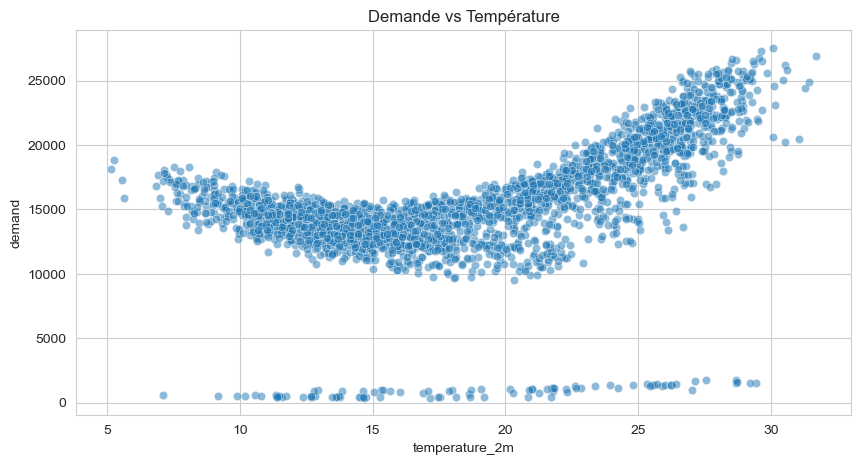

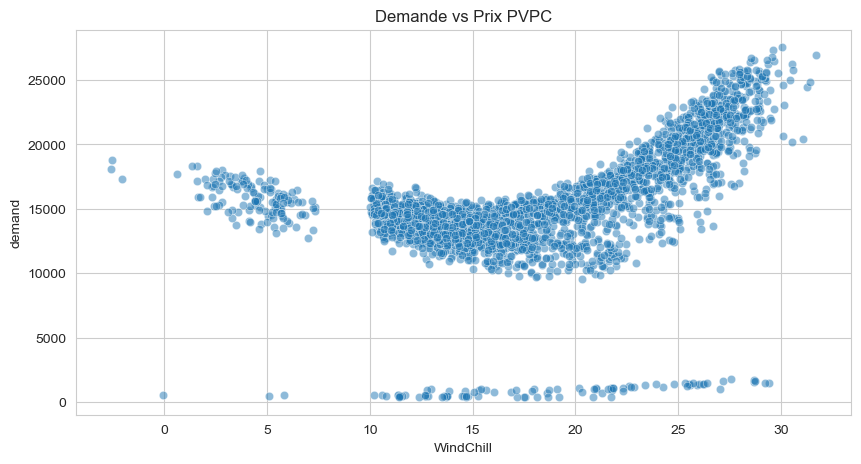

In [10]:
plt.figure()
sns.scatterplot(x='temperature_2m', y='demand', data=df, alpha=0.5)
plt.title("Demande vs Température")
plt.show()

plt.figure()
sns.scatterplot(x='WindChill', y='demand', data=df, alpha=0.5)
plt.title("Demande vs Prix PVPC")
plt.show()

## 9. Jours fériés vs ouvrés

In [12]:
# plt.figure()
# df.boxplot(column='demand', by='is_holiday')
# plt.title("Demande ouvrés vs fériés")
# plt.suptitle("")
# plt.ylabel("Demand")
# plt.show()

N'as pas ete selectionne

## 10. Détection d'anomalies (rolling z-score 7j)

Aucune anomalie (|z|>3) détectée


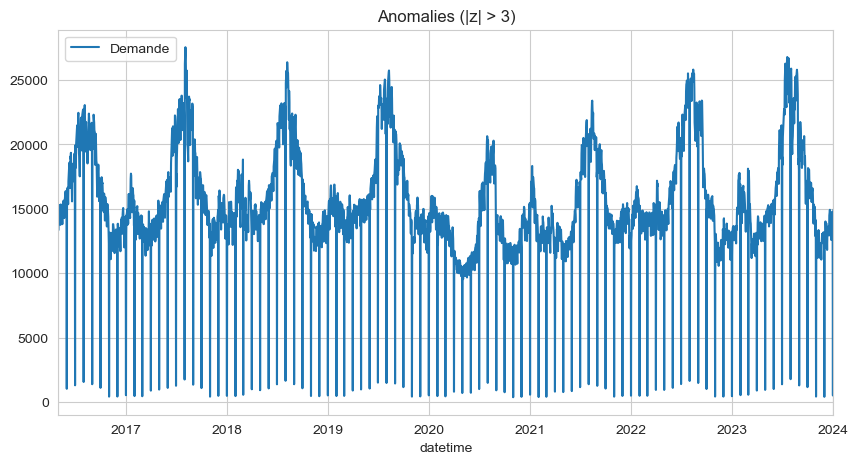

In [13]:
rolling_mean = df['demand'].rolling(7).mean()
rolling_std  = df['demand'].rolling(7).std()
z_score = (df['demand'] - rolling_mean) / rolling_std
anoms = df[z_score.abs() > 3]
plt.figure()
df['demand'].plot(label='Demande')
if not anoms.empty:
    anoms['demand'].plot(style='ro', label='Anomalies')
else:
    print("Aucune anomalie (|z|>3) détectée")
plt.legend()
plt.title("Anomalies (|z| > 3)")
plt.show()

## 11. Tests de stationnarité (ADF, KPSS)

In [14]:
from statsmodels.tsa.stattools import adfuller, kpss
series = df['demand']
print("→ Test ADF (Augmented Dickey-Fuller)")
result_adf = adfuller(series.dropna())
print(f"ADF Statistic: {result_adf[0]:.4f}")
print(f"p-value: {result_adf[1]:.4f}")
for key, value in result_adf[4].items():
    print(f"   {key}: {value:.4f}")
if result_adf[1] < 0.05:
    print("✅ La série est stationnaire (rejet de H0)")
else:
    print("❌ La série n'est pas stationnaire (échec du rejet de H0)")

print("\n→ Test KPSS")
result_kpss = kpss(series.dropna(), regression='c')
print(f"KPSS Statistic: {result_kpss[0]:.4f}")
print(f"p-value: {result_kpss[1]:.4f}")
for key, value in result_kpss[3].items():
    print(f"   {key}: {value:.4f}")
if result_kpss[1] < 0.05:
    print("❌ La série n'est pas stationnaire (rejet de H0)")
else:
    print("✅ La série est stationnaire (échec du rejet de H0)")

→ Test ADF (Augmented Dickey-Fuller)
ADF Statistic: -4.2822
p-value: 0.0005
   1%: -3.4327
   5%: -2.8626
   10%: -2.5673
✅ La série est stationnaire (rejet de H0)

→ Test KPSS
KPSS Statistic: 0.2134
p-value: 0.1000
   10%: 0.3470
   5%: 0.4630
   2.5%: 0.5740
   1%: 0.7390
✅ La série est stationnaire (échec du rejet de H0)


C:\Users\NANKOULI\AppData\Local\Temp\ipykernel_21484\4165473574.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss = kpss(series.dropna(), regression='c')


## 12. Différenciation et stationnarité

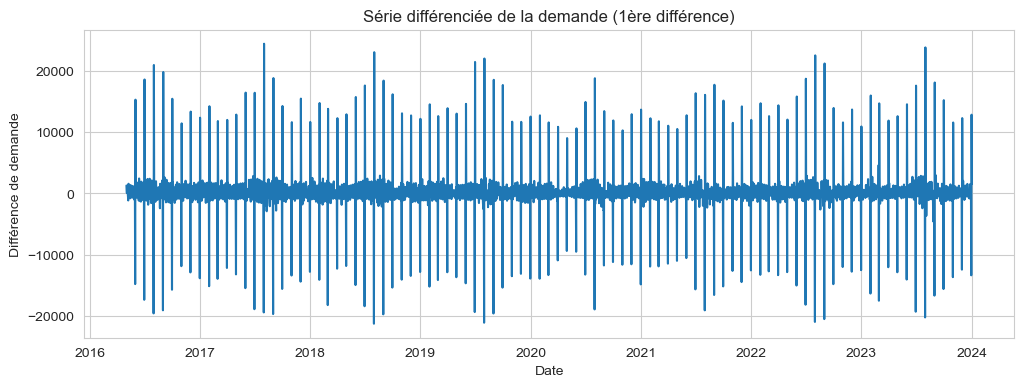

→ Test ADF (série différenciée)
ADF Statistic: -16.3591
p-value: 0.0000
   1%%: -3.4327
   5%%: -2.8626
   10%%: -2.5673
✅ La série est stationnaire (rejet de H0)

→ Test KPSS (série différenciée)
KPSS Statistic: 0.0949
p-value: 0.1000
   10%%: 0.3470
   5%%: 0.4630
   2.5%%: 0.5740
   1%%: 0.7390
✅ La série est stationnaire (échec du rejet de H0)


C:\Users\NANKOULI\AppData\Local\Temp\ipykernel_21484\1259990432.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss = kpss(series_diff, regression='c')


In [15]:
series_diff = series.diff().dropna()
plt.figure(figsize=(12, 4))
plt.plot(series_diff)
plt.title("Série différenciée de la demande (1ère différence)")
plt.xlabel("Date")
plt.ylabel("Différence de demande")
plt.grid(True)
plt.show()

# Test ADF sur la série différenciée
result_adf = adfuller(series_diff)
print("→ Test ADF (série différenciée)")
print(f"ADF Statistic: {result_adf[0]:.4f}")
print(f"p-value: {result_adf[1]:.4f}")
for key, value in result_adf[4].items():
    print(f"   {key}%: {value:.4f}")
if result_adf[1] < 0.05:
    print("✅ La série est stationnaire (rejet de H0)")
else:
    print("❌ La série n'est pas stationnaire")

# Test KPSS sur la série différenciée
result_kpss = kpss(series_diff, regression='c')
print("\n→ Test KPSS (série différenciée)")
print(f"KPSS Statistic: {result_kpss[0]:.4f}")
print(f"p-value: {result_kpss[1]:.4f}")
for key, value in result_kpss[3].items():
    print(f"   {key}%: {value:.4f}")
if result_kpss[1] > 0.05:
    print("✅ La série est stationnaire (échec du rejet de H0)")
else:
    print("❌ La série n'est pas stationnaire")

## 13. Modélisation ARIMA automatique (auto_arima)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=54376.657, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=53716.320, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=53035.915, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=54374.657, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=53013.979, Time=0.94 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=53030.255, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=53017.528, Time=1.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=53017.025, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=53443.299, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.92 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=53011.979, Time=0.39 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=53033.863, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=53714.320, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=53028.175, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0]  

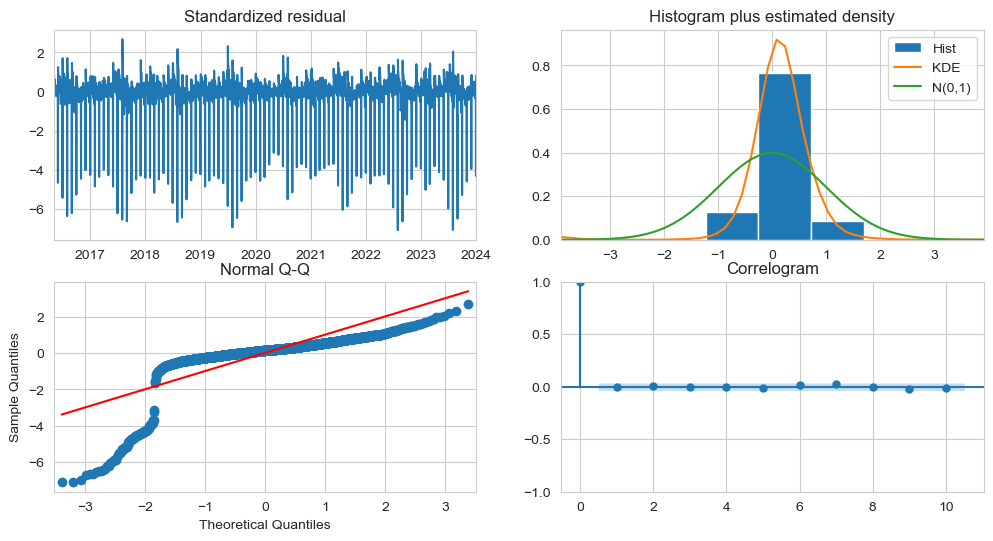

In [16]:
import pmdarima as pm
model = pm.auto_arima(
    series,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,           # Détection automatique du degré de différenciation
    seasonal=False,   # On active le mode saisonnier plus tard si besoin
    trace=True,       # Affiche les essais
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
print(model.summary())
model.plot_diagnostics(figsize=(12, 6))
plt.show()

# Résumé et conclusions

- Les séries de demande présentent une forte saisonnalité et des effets calendaires marqués.
- La corrélation avec la température et certains indices météo est notable.
- Les tests de stationnarité montrent qu’une différenciation d’ordre 1 suffit généralement.
- Les modèles ARIMA simples peuvent déjà capturer une partie de la dynamique, mais des modèles plus avancés (saisonniers, exogènes) sont à tester.
- Les fichiers analysés sont issus de `data/processed/` et peuvent être utilisés pour la modélisation prédictive.